In [1]:
from dotenv import load_dotenv
import os
from typing import List, Dict, Any, Optional, Union

load_dotenv()

import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm

# Import from our Classes module
from Classes.model_classes import SQLLineageExtractor, SQLLineageResult, create_sql_lineage_extractor
from Classes.regexp_extractor import RegexSQLExtractor
from Classes.validation_classes import SQLLineageValidator
from Classes.prompt_refiner import HuggingFaceSQLLineageAgent


MODEL = "Qwen/Qwen3-Coder-30B-A3B-Instruct"
PROVIDER = "scaleway"
HF_TOKEN = os.environ.get("HF_TOKEN")

# Get the current working directory
current_dir = Path.cwd()
# Construct the path relative to current directory
file_path = current_dir / 'data' / 'SQL.txt'
file_path_valid = current_dir / 'data' / 'SQL_valid.txt'
file_path_log = current_dir / 'data' / 'logs.json'

# Read file with example
with open(file_path, "r", encoding="utf-8") as f:
    SQL = f.read()

# Read file with example (valid for LLM)
with open(file_path_valid, "r", encoding="utf-8") as f:
    SQL_valid = f.read()

PROMPT = """Please extract source-to-target lineage from the SQL query with the following requirements:

### SQL Lineage Extraction Task
Extract source-to-target lineage from the SQL statement below. Return ONLY valid JSON containing:
- "target": The main object being created or modified (fully qualified name)
- "sources": List of DISTINCT base tables/views (fully qualified names)"""

/Users/nikolajabramov/PycharmProjects/PythonProject/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Create extractor
extractor = create_sql_lineage_extractor(
    model=MODEL,
    provider=PROVIDER,
    hf_token=HF_TOKEN,
    max_new_tokens=2048,
    do_sample=False,
    max_retries=3,
    use_pydantic_parser=True, 
    human_prompt_template = PROMPT
    
)

# Create agent – it will reuse the extractor and also its own chat model (same config)
agent = HuggingFaceSQLLineageAgent(
    model=MODEL,
    provider=PROVIDER,
    hf_token=os.environ["HF_TOKEN"],
    extractor=extractor
)

re_extractor = RegexSQLExtractor()

In [3]:
print(extractor.human_prompt_template)

Please extract source-to-target lineage from the SQL query with the following requirements:

### SQL Lineage Extraction Task
Extract source-to-target lineage from the SQL statement below. Return ONLY valid JSON containing:
- "target": The main object being created or modified (fully qualified name)
- "sources": List of DISTINCT base tables/views (fully qualified names)


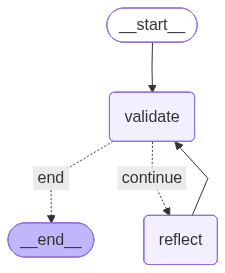

In [4]:
agent.create_workflow().compile()

In [5]:
result = agent.optimize_prompt_sync(
    sql=SQL,
    expected_result=re_extractor.extract(SQL),
    output_file=file_path_log,   # saves full history
    verbose=True  
)

print("Optimized prompt:\n", result["optimized_prompt"])
print(f"F1 Score: {result['f1_score']:.4f}")


STARTING PROMPT OPTIMIZATION (LangChain Hugging Face Agent)

📝 Initial prompt preview:
Please extract source-to-target lineage from the SQL query with the following requirements:

### SQL Lineage Extraction Task
Extract source-to-target lineage from the SQL statement below. Return ONLY ...


################################################################################
ITERATION 1 / 5
################################################################################

################################################################################
VALIDATE NODE - Iteration 1/5
################################################################################

VALIDATION

EXTRACTION ATTEMPT 1/3
Attempt 1/3 failed: [Errno 54] Connection reset by peer. Retrying in 2s...
✓ Extraction successful in 34.26s

EXTRACTION ATTEMPT 1/3
✓ Extraction successful in 4.62s

REFLECTION - Iteration 1
✓ Improved prompt generated (1208 chars)

#################################################################